<a href="https://colab.research.google.com/github/YaninaK/churn-prediction/blob/main/notebooks/01_EDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Прогнозирование оттока клиентов

---



---



* Методика подготовки данных
* Построение модели
* Оценки качества модели
* Анализ полученных результатов
* Оценка практической применимости модели

Необходимо построить модель прогнозирования оттока клиентов по имеющимся признакам (колонка churn в файле – целевая переменная), кратко описать методику подготовки данных, построения модели и оценки её качества. Желательно провести анализ полученных результатов и оценить практическую применимость модели.
Результат может быть представлен, например, в виде jupyter-ноутбука с кодом. Данные находятся в приложенном файле.

+ написать pipeline в виде отдельного файла, класса. Где на вход сырые данные, на выход - скор балл.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import pandas as pd
import numpy as np
import joblib
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf

from scipy.stats import chi2_contingency, chisquare,  kstest

import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
PATH = '/content/drive/MyDrive/ML_projects/06_Churn_prediction/'

## 1. Загрузка данных

In [4]:
df = pd.read_csv(PATH + 'data/01_raw/telco-customer-churn.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20468 entries, 0 to 20467
Data columns (total 29 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   age                                   20468 non-null  int64  
 1   annualincome                          20468 non-null  int64  
 2   calldroprate                          20468 non-null  float64
 3   callfailurerate                       20468 non-null  float64
 4   callingnum                            20468 non-null  int64  
 5   customerid                            20468 non-null  int64  
 6   customersuspended                     20468 non-null  object 
 7   education                             20468 non-null  object 
 8   gender                                20468 non-null  object 
 9   homeowner                             20468 non-null  object 
 10  maritalstatus                         20468 non-null  object 
 11  monthlybilledam

In [5]:
TARGET_NAME = 'churn'
ID = 'customerid'

## 2. EDA

In [6]:
df.nunique()

age                                       68
annualincome                            9508
calldroprate                               8
callfailurerate                            4
callingnum                              9525
customerid                              9525
customersuspended                          2
education                                  4
gender                                     2
homeowner                                  2
maritalstatus                              2
monthlybilledamount                      120
noadditionallines                          1
numberofcomplaints                         4
numberofmonthunpaid                        8
numdayscontractequipmentplanexpiring     100
occupation                                 3
penaltytoswitch                          500
state                                     50
totalminsusedinlastmonth                 500
unpaidbalance                            250
usesinternetservice                        2
usesvoices

* Признаки noadditionallines и year не изменяется - их использовать не будем.
* Данные представлены за 3 месяца.

### 2.1. Целевая переменная

In [7]:
agg_1 = df.groupby(ID, as_index=False)[TARGET_NAME].max()
agg_1

,customerid,churn
0,1,0
1,2,0
2,3,0
3,4,0
4,5,0
...,...,...
9520,9521,0
9521,9522,0
9522,9523,1
9523,9524,0


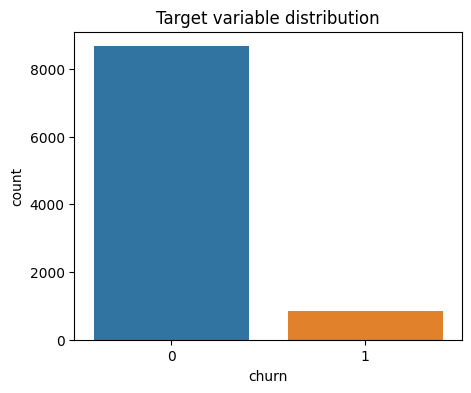

In [8]:
plt.figure(figsize=(5, 4))
sns.countplot(x=TARGET_NAME, data=agg_1)
plt.title('Target variable distribution')
plt.show()

In [9]:
agg_1[TARGET_NAME].value_counts()

0    8664
1     861
Name: churn, dtype: int64

In [10]:
agg_1[TARGET_NAME].value_counts(normalize=True)

0    0.909606
1    0.090394
Name: churn, dtype: float64

* Доступны данные по 9525 клиентам
* Отток клиентов составляет 9%

In [11]:
client_data_changes = df.groupby(ID).nunique().mean()
client_data_changes

age                                     1.000000
annualincome                            1.000000
calldroprate                            1.000000
callfailurerate                         1.000000
callingnum                              1.000000
customersuspended                       1.000000
education                               1.000000
gender                                  1.000000
homeowner                               1.000000
maritalstatus                           1.000000
monthlybilledamount                     1.000000
noadditionallines                       1.000000
numberofcomplaints                      1.000000
numberofmonthunpaid                     1.000000
numdayscontractequipmentplanexpiring    1.000000
occupation                              1.000000
penaltytoswitch                         1.000000
state                                   1.000000
totalminsusedinlastmonth                1.000000
unpaidbalance                           1.000000
usesinternetservice 

* Значение целевой функции не изменяется во времени.
* В среднем, по клиентам доступны данные только за 2 временных промежутка.
* На заданном промежутке времени изменяются только totalcallduration и avgcallduration.

In [12]:
def seq_padding(x, T=3):
  x = x.tolist()
  if len(x) < T:
    n = T - len(x)
    return x + n * [0]
  return x

agg_2 = df.groupby(ID).agg(
    no_info_1 = ('month', lambda x: 1 if x.min() > 1 else 0),
    no_info_3 = ('month', lambda x: 1 if x.max() < 3 else 0),
    seq_len = ('totalcallduration', lambda x: len(x.tolist())),
    seq_total = ('totalcallduration', seq_padding),
    seq_avg = ('avgcallduration', seq_padding),
)
agg_2 = pd.concat([agg_2, agg_1.set_index(ID)], axis=1)
agg_2

,no_info_1,no_info_3,seq_len,seq_total,seq_avg,churn
customerid,,,,,,
1,0,1,2,"[5971, 3981, 0]","[663, 995, 0]",0
2,0,1,2,"[7379, 1729, 0]","[737, 432, 0]",0
3,0,1,2,"[3122, 2769, 0]","[624, 553, 0]",0
4,0,1,2,"[834, 5868, 0]","[834, 838, 0]",0
5,0,1,2,"[1886, 2602, 0]","[628, 867, 0]",0
...,...,...,...,...,...,...
9521,0,1,2,"[2580, 4191, 0]","[860, 838, 0]",0
9522,0,1,2,"[1709, 3400, 0]","[569, 680, 0]",0
9523,0,1,2,"[3872, 7651, 0]","[553, 850, 0]",1


In [13]:
pd.pivot_table(agg_2, index='seq_len', values=TARGET_NAME, aggfunc='sum', margins=True,)

,churn
seq_len,
1,9
2,702
3,150
All,861


* 81.5% случаев оттока приходится на временной промежуток 2 месяца, 17.4% - 3 месяца

In [14]:
pd.pivot_table(agg_2, index='seq_len', values=TARGET_NAME, aggfunc='mean',)

,churn
seq_len,
1,0.094737
2,0.088670
3,0.099141


In [15]:
agg_2['seq_len'].value_counts(normalize=True).sort_index()

1    0.009974
2    0.831181
3    0.158845
Name: seq_len, dtype: float64

In [16]:
agg_2['no_info_1'].value_counts(normalize=True)

0    0.994751
1    0.005249
Name: no_info_1, dtype: float64

In [17]:
agg_2['no_info_3'].value_counts(normalize=True)

1    0.839685
0    0.160315
Name: no_info_3, dtype: float64

In [18]:
agg_2[(agg_2['no_info_3'] == 1) & (agg_2[TARGET_NAME] == 0)].shape[0] / agg_2[agg_2['no_info_3'] == 1].shape[0]

0.9111027756939235

* У клиентов, по которым доступна информация за 3 месяца (16% от общего числа клиентов), отток существенно выше, чем у тех по которым доступна информация за 2 месяца.

* По 84% клиентов отсутствует информация за третий месяц, причем более 91% из них обозначены как действующие клиенты (не отток).

* У клиентов, по которым доступна информация за 1 месяц отток тоже выше, чем у тех по которым доступна информация за 2 месяца. Это может быть связано с относительно небольшим числом наблюдений: всего у 1% клиентов информация доступна лишь за один месяц, и наблюдалось только 9 случаев оттока.
Кроме того, по 0.5% клиентов отсутствует информация за первый месяц, хотя это могли быть и новые клиенты.

### 2.2. Формирование датасета

In [19]:
vars_to_drop = [
    'totalcallduration', 'avgcallduration', 'noadditionallines', 'year', 'month',
]

def generate_dataset(df, vars_to_drop=vars_to_drop):
  features = [i for i in df.columns if not i in vars_to_drop]
  agg_const =  df[features].groupby(ID)[features].first()
  agg_add = df.groupby(ID).agg(
      no_info_1 = ('month', lambda x: 1 if x.min() > 1 else 0),
      no_info_3 = ('month', lambda x: 1 if x.max() < 3 else 0),
      seq_total_max = ('totalcallduration', 'max'),
      seq_total_min = ('totalcallduration', 'min'),
      seq_avg_max = ('avgcallduration', 'max'),
      seq_avg_min = ('avgcallduration', 'min'),
      seq_total_range = ('totalcallduration', lambda x: x.max()-x.min()),
      seq_avg_range = ('avgcallduration', lambda x: x.max()-x.min()),
      seq_total = ('totalcallduration', seq_padding),
      seq_avg = ('avgcallduration', seq_padding),
  )

  return pd.concat([agg_const, agg_add], axis=1)

In [20]:
df = generate_dataset(df)
df.sample(2)

,age,annualincome,calldroprate,callfailurerate,callingnum,customerid,customersuspended,education,gender,homeowner,...,no_info_1,no_info_3,seq_total_max,seq_total_min,seq_avg_max,seq_avg_min,seq_total_range,seq_avg_range,seq_total,seq_avg
customerid,,,,,,,,,,,,,,,,,,,,,
723,40,48577,0.04,0.03,4251033415,723,Yes,High School or below,Male,Yes,...,0,0,2686,191,892,191,2495,701,"[1784, 2686, 191]","[892, 671, 191]"
4228,42,6918,0.02,0.02,4251071869,4228,Yes,High School or below,Female,No,...,0,1,4444,3317,634,473,1127,161,"[4444, 3317, 0]","[634, 473, 0]"


In [21]:
train, test = train_test_split(df, test_size=0.3, random_state=24, stratify=df[TARGET_NAME])
valid, test = train_test_split(test, test_size=0.5, random_state=24, stratify=test[TARGET_NAME])

train.shape,  valid.shape, test.shape

((6667, 34), (1429, 34), (1429, 34))

### 2.3. Переменные, изменяющиеся на заданном временном промежутке

In [22]:
def seq_padding(x, T=3):
  x = x.tolist()
  if len(x) < T:
    n = T - len(x)
    return x + n * [0]
  return x


def preprocess_seq(df):
    seq = np.array(
          [df['seq_total'].tolist(), df['seq_avg'].tolist()]
      ).reshape(2, -1).T

    return seq


def fit_transform_seq(df):
  seq = preprocess_seq(df)

  scaler = StandardScaler()
  seq = scaler.fit_transform(seq)

  return scaler, seq.reshape(-1, 3, 2)


def transform_seq(df, scaler):
  seq = preprocess_seq(df)
  seq = scaler.transform(seq)

  return seq.reshape(-1, 3, 2)

In [23]:
scaler, seq_train = fit_transform_seq(train)
seq_valid = transform_seq(valid, scaler)
seq_test = transform_seq(test, scaler)

seq_train.shape, seq_valid.shape, seq_test.shape

((6667, 3, 2), (1429, 3, 2), (1429, 3, 2))

In [24]:
METRICS = [
      tf.keras.metrics.BinaryCrossentropy(name='cross entropy'),  # same as model's loss
      tf.keras.metrics.MeanSquaredError(name='Brier score'),
      tf.keras.metrics.TruePositives(name='tp'),
      tf.keras.metrics.FalsePositives(name='fp'),
      tf.keras.metrics.TrueNegatives(name='tn'),
      tf.keras.metrics.FalseNegatives(name='fn'),
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall'),
      tf.keras.metrics.AUC(name='auc'),
      tf.keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
]

params_LSTM = {
    'input_sequence_length' : 3,
    'n_features': 2,
    'n_units': 4,
}

def get_LSTM_model(
    input_sequence_length: int,
    n_features: int,
    n_units: int,
    output_bias=None,
    metrics=METRICS,
):
  if output_bias is not None:
    output_bias = tf.keras.initializers.Constant(output_bias)

  lstm_inputs = tf.keras.layers.Input(
      shape=(input_sequence_length, n_features), name="lstm_inputs"
  )
  lstm_output = tf.keras.layers.LSTM(n_units, name="lstm_output")(lstm_inputs)

  outputs = tf.keras.layers.Dense(
      1, activation=tf.keras.activations.sigmoid, name="outputs",
      bias_initializer=output_bias
  )(lstm_output)

  model = tf.keras.models.Model(
      lstm_inputs, outputs, name="lstm_model"
  )
  model.compile(
      optimizer=tf.keras.optimizers.Adam(),
      loss=tf.keras.losses.BinaryCrossentropy(),
      metrics=metrics
  )

  return model


def get_initial_bias_and_class_weight(train):
  pos = (train[TARGET_NAME]==1).sum()
  neg = (train[TARGET_NAME]==0).sum()

  initial_bias = np.log([pos/neg])
  print(f'initial_bias: {initial_bias}\n')

  total = train.shape[0]
  weight_for_0 = (1 / neg) * (total / 2.0)
  weight_for_1 = (1 / pos) * (total / 2.0)

  class_weight = {0: weight_for_0, 1: weight_for_1}
  print('Weight for class 0: {:.2f}'.format(weight_for_0))
  print('Weight for class 1: {:.2f}'.format(weight_for_1))

  return initial_bias, class_weight

In [25]:
initial_bias, class_weight = get_initial_bias_and_class_weight(train)

initial_bias: [-2.30820773]

Weight for class 0: 0.55
Weight for class 1: 5.53


In [26]:
model_path = "models/LSTM_model.keras"
history_path = "models/model_LSTM_training_history.joblib"

regenerate = False
if regenerate:
  lstm_model = get_LSTM_model(**params_LSTM, output_bias=initial_bias)
  n_epochs = 20
  batch_size = 64
  reduce_lr = tf.keras.callbacks.LearningRateScheduler(
      lambda epoch: 5e-3 * 0.95 ** epoch
  )
  early_stopping = tf.keras.callbacks.EarlyStopping(
      monitor='val_prc',
      patience=10,
      min_delta=1e-05,
      verbose=1,
      mode="max",
      restore_best_weights=True,
  )

  history = lstm_model.fit(
      seq_train, train[TARGET_NAME],
      epochs=n_epochs,
      validation_data=(seq_valid, valid[TARGET_NAME]),
      class_weight=class_weight,
      batch_size=batch_size,
      verbose=0,
      callbacks=[reduce_lr, early_stopping],
      shuffle=True,
      workers=-1,
      use_multiprocessing=True
  )
  lstm_model.save(PATH + model_path)
  joblib.dump(history, PATH + history_path)

else:
  lstm_model = tf.keras.models.load_model(PATH + model_path)
  history = joblib.load(PATH + history_path)

In [27]:
lstm_model.summary()

Model: "lstm_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_inputs (InputLayer)    [(None, 3, 2)]            0         
                                                                 
 lstm_output (LSTM)          (None, 4)                 112       
                                                                 
 outputs (Dense)             (None, 1)                 5         
                                                                 
Total params: 117 (468.00 Byte)
Trainable params: 117 (468.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [28]:
def plot_loss(history):
  plt.semilogy(history.epoch, history.history['loss'], label='Train')
  plt.semilogy(
      history.epoch, history.history['val_loss'], label='Valid', linestyle="--"
  )
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.title("LSTM model Loss")
  plt.legend()

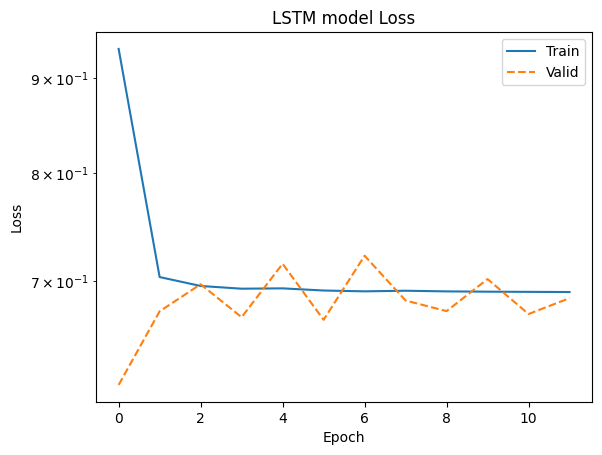

In [29]:
plot_loss(history)

In [30]:
results = lstm_model.evaluate(seq_train, train[TARGET_NAME], batch_size=64, verbose=0)
print("Loss: {:0.4f}".format(results[0]))

Loss: 0.6767


In [31]:
baseline_results = lstm_model.evaluate(
    seq_test, test[TARGET_NAME], batch_size=64, verbose=0
)
for name, value in zip(lstm_model.metrics_names, baseline_results):
  print(name, ': ', value)
print()

loss :  0.6771835088729858
cross entropy :  0.6771835088729858
Brier score :  0.2420739233493805
tp :  49.0
fp :  501.0
tn :  799.0
fn :  80.0
accuracy :  0.593421995639801
precision :  0.08909090608358383
recall :  0.3798449635505676
auc :  0.4763416647911072
prc :  0.08215682953596115



In [32]:
def get_ts_embedings_model(model):
  sharing_input = model.get_layer('lstm_inputs').get_output_at(0)
  sharing_output = model.get_layer('lstm_output').get_output_at(0)
  emb_model = tf.keras.Model(sharing_input, sharing_output)

  return emb_model


def get_ts_embeddings(df, seq, emb_model):
  emb_lstm = emb_model.predict(seq)
  cols = [f'ts_emb_{i}' for i in range(emb_lstm.shape[1])]

  return pd.DataFrame(emb_lstm, index=df.index, columns=cols)

In [33]:
emb_model = get_ts_embedings_model(lstm_model)

emb_lstm_train = get_ts_embeddings(train, seq_train, emb_model)
emb_lstm_valid = get_ts_embeddings(valid, seq_valid, emb_model)
emb_lstm_test = get_ts_embeddings(test, seq_test, emb_model)

45/45 [==============================] - 0s 3ms/step


In [34]:
emb_lstm_train.sample(2)

,ts_emb_0,ts_emb_1,ts_emb_2,ts_emb_3
customerid,,,,
5625,0.729480,0.471087,-0.126450,0.655657
5327,0.772001,0.502263,-0.106407,0.711606


In [35]:
train = pd.concat([train, emb_lstm_train], axis=1)
valid = pd.concat([valid, emb_lstm_valid], axis=1)
test = pd.concat([test, emb_lstm_test], axis=1)

train.sample(2)

,age,annualincome,calldroprate,callfailurerate,callingnum,customerid,customersuspended,education,gender,homeowner,...,seq_avg_max,seq_avg_min,seq_total_range,seq_avg_range,seq_total,seq_avg,ts_emb_0,ts_emb_1,ts_emb_2,ts_emb_3
customerid,,,,,,,,,,,,,,,,,,,,,
2557,59,187793,0.05,0.01,4251097193,2557,Yes,Bachelor or equivalent,Male,Yes,...,1215,534,2527,681,"[2437, 3742, 1215]","[812, 534, 1215]",0.498756,0.376072,-0.788682,0.376984
4842,55,89304,0.00,0.02,4251060980,4842,Yes,High School or below,Male,Yes,...,1031,739,3081,292,"[8254, 5173, 0]","[1031, 739, 0]",0.778983,0.444271,-0.154047,0.640520


In [36]:
selected_ts_features = ['ts_emb_0',	'ts_emb_1',	'ts_emb_2',	'ts_emb_3']

### 2.4. Категориальные переменные

In [37]:
def fit_transform_embeddings(df: pd.DataFrame, feature: str, output_dim: int,):
  vocab =  df[feature].unique().tolist()
  str_lookup_layer = tf.keras.layers.StringLookup(vocabulary=vocab)
  lookup_and_embed = tf.keras.Sequential(
      [
          tf.keras.layers.InputLayer(input_shape=[], dtype=tf.string),
          str_lookup_layer,
          tf.keras.layers.Embedding(
              input_dim=str_lookup_layer.vocabulary_size(),
              output_dim=output_dim,
          )
      ]
  )
  emb = lookup_and_embed(tf.constant(df[feature])).numpy()
  cols = [f'{feature}_{i}' for i in range(output_dim)]

  return pd.DataFrame(emb, index=df.index, columns=cols), lookup_and_embed


def transform_embeddings(df, feature, output_dim, lookup_and_embed):
  emb = lookup_and_embed(tf.constant(df[feature])).numpy()
  cols = [f'{feature}_{i}' for i in range(output_dim)]

  return pd.DataFrame(emb, index=df.index, columns=cols)


In [38]:
categorical_variables = train.dtypes[train.dtypes=='object'].index.tolist()[:-2]

categorical_info = train[categorical_variables].nunique()
categorical_info

customersuspended       2
education               4
gender                  2
homeowner               2
maritalstatus           2
occupation              3
state                  50
usesinternetservice     2
usesvoiceservice        2
dtype: int64

#### 2.3.1. Ембеддинги

In [39]:
feature = 'state'
df.groupby(feature)[TARGET_NAME].mean().sort_values()

state
VT    0.034884
NE    0.050847
AL    0.050955
NJ    0.056818
LA    0.058824
MD    0.065421
MN    0.071090
TN    0.072289
IN    0.075758
GA    0.075949
IL    0.076023
MS    0.077348
VA    0.078947
AK    0.079812
FL    0.080569
DE    0.081633
NV    0.082418
CT    0.083832
TX    0.084158
MI    0.084270
ME    0.085366
WI    0.086538
NM    0.087912
MO    0.088889
OH    0.089552
MA    0.090426
MT    0.091346
NH    0.091743
WA    0.092233
OR    0.093407
KS    0.094444
WY    0.097087
RI    0.097143
HI    0.097778
CO    0.098522
AZ    0.098522
NC    0.101796
PA    0.101942
ID    0.104167
SD    0.104478
WV    0.108434
NY    0.108491
KY    0.109005
AR    0.109756
UT    0.110000
ND    0.111111
OK    0.112360
IA    0.117949
CA    0.136792
SC    0.155080
Name: churn, dtype: float64

In [40]:
output_dim = 4
emb_train, lookup_and_embed = fit_transform_embeddings(train, feature, output_dim)
emb_valid = transform_embeddings(valid, feature, output_dim, lookup_and_embed)
emb_test = transform_embeddings(test, feature, output_dim,  lookup_and_embed)

train = pd.concat([train, emb_train], axis=1)
valid = pd.concat([valid, emb_valid], axis=1)
test = pd.concat([test, emb_test], axis=1)

categorical_variables = [i for i in categorical_variables if i != feature]
train.sample(2)

,age,annualincome,calldroprate,callfailurerate,callingnum,customerid,customersuspended,education,gender,homeowner,...,seq_total,seq_avg,ts_emb_0,ts_emb_1,ts_emb_2,ts_emb_3,state_0,state_1,state_2,state_3
customerid,,,,,,,,,,,,,,,,,,,,,
2565,40,123510,0.06,0.01,4251028562,2565,Yes,Bachelor or equivalent,Female,Yes,...,"[1237, 3345, 37]","[618, 669, 37]",0.671484,0.526769,-0.069579,0.744760,-0.00677,-0.011011,0.038564,-0.03797
9065,53,53237,0.03,0.03,4251090603,9065,Yes,Master or equivalent,Female,Yes,...,"[1670, 4590, 0]","[835, 573, 0]",0.703062,0.501764,-0.089571,0.688209,-0.00677,-0.011011,0.038564,-0.03797


#### 2.3.2. One-hot encoding

In [41]:
def fit_transform_one_hot_encoding(df, feature):
  vocab = df[feature].unique().tolist()
  str_lookup_layer = tf.keras.layers.StringLookup(
      vocabulary=vocab, output_mode="one_hot", name="str_lookup_layer"
  )
  arr = str_lookup_layer(train[feature]).numpy()[:, 1:]

  return pd.DataFrame(arr, index=df.index, columns=vocab), str_lookup_layer


def transform_one_hot_encoding(df, feature, str_lookup_layer):
  arr = str_lookup_layer(df[feature]).numpy()[:, 1:]

  return pd.DataFrame(arr, index=df.index, columns=str_lookup_layer.get_vocabulary()[1:])

In [42]:
for feature in categorical_variables:
  print(f'{df.groupby(feature)[TARGET_NAME].mean().sort_values(ascending=False)}\n')

customersuspended
No     0.106796
Yes    0.090031
Name: churn, dtype: float64

education
PhD or equivalent         0.100840
Bachelor or equivalent    0.096073
High School or below      0.091024
Master or equivalent      0.073611
Name: churn, dtype: float64

gender
Female    0.092623
Male      0.088052
Name: churn, dtype: float64

homeowner
No     0.094013
Yes    0.089490
Name: churn, dtype: float64

maritalstatus
Single     0.096462
Married    0.084066
Name: churn, dtype: float64

occupation
Non-technology Related Job    0.097875
Others                        0.088475
Technology Related Job        0.085413
Name: churn, dtype: float64

usesinternetservice
Yes    0.110512
No     0.089578
Name: churn, dtype: float64

usesvoiceservice
No     0.090552
Yes    0.088812
Name: churn, dtype: float64



In [43]:
for feature in ['education', 'occupation']:
  oh_train, str_lookup_layer = fit_transform_one_hot_encoding(train, feature)
  oh_valid = transform_one_hot_encoding(valid, feature, str_lookup_layer)
  oh_test = transform_one_hot_encoding(test, feature, str_lookup_layer)

  train = pd.concat([train, oh_train], axis=1)
  valid = pd.concat([valid, oh_valid], axis=1)
  test = pd.concat([test, oh_test], axis=1)

train.sample(2)

,age,annualincome,calldroprate,callfailurerate,callingnum,customerid,customersuspended,education,gender,homeowner,...,state_1,state_2,state_3,High School or below,Bachelor or equivalent,Master or equivalent,PhD or equivalent,Others,Non-technology Related Job,Technology Related Job
customerid,,,,,,,,,,,,,,,,,,,,,
3450,18,193503,0.06,0.01,4251037180,3450,Yes,Bachelor or equivalent,Male,Yes,...,0.026489,-0.017381,-0.008183,0.0,1.0,0.0,0.0,1.0,0.0,0.0
9184,18,143732,0.04,0.00,4251018311,9184,Yes,High School or below,Female,No,...,-0.029340,0.003562,-0.010718,1.0,0.0,0.0,0.0,0.0,1.0,0.0


In [44]:
categorical_variables = [i for i in categorical_variables if not i in ['education', 'occupation']]

#### 2.3.3. Бинарные признаки

In [45]:
def map_categorical_features(df):
  X = df.copy()
  X['customersuspended'] = X['customersuspended'].map({'Yes': 1, 'No': 0})
  X['gender'] = X['gender'].map({'Male': 1, 'Female': 0})
  X['homeowner'] = X['homeowner'].map({'Yes': 1,'No': 0})
  X['maritalstatus'] = X['maritalstatus'].map({'Single': 1, 'Married': 0})
  X['usesinternetservice'] = X['usesinternetservice'].map({'Yes': 1, 'No': 0})
  X['usesvoiceservice'] = X['usesvoiceservice'].map({'Yes': 1, 'No': 0 })

  return X

In [46]:
train = map_categorical_features(train)
valid = map_categorical_features(valid)
test = map_categorical_features(test)

train[categorical_variables].sample(2)

,customersuspended,gender,homeowner,maritalstatus,usesinternetservice,usesvoiceservice
customerid,,,,,,
570,1,1,1,0,0,0
4887,1,0,1,1,1,0


In [47]:
selected_categorical_features = categorical_variables + [
    'state_0',
    'state_1',
    'state_2',
    'state_3',
    'High School or below',
    'Bachelor or equivalent',
    'Master or equivalent',
    'PhD or equivalent',
    'Non-technology Related Job',
    'Technology Related Job',
    'Others',
]
selected_categorical_features

['customersuspended',
 'gender',
 'homeowner',
 'maritalstatus',
 'usesinternetservice',
 'usesvoiceservice',
 'state_0',
 'state_1',
 'state_2',
 'state_3',
 'High School or below',
 'Bachelor or equivalent',
 'Master or equivalent',
 'PhD or equivalent',
 'Non-technology Related Job',
 'Technology Related Job',
 'Others']

### 2.5. Численные переменные

In [48]:
def get_correlated_features(df, numeric_variables, threshold=0.95):
  corr = df[numeric_variables].corr()
  for i in range(len(numeric_variables)):
    for j in range(i + 1, len(numeric_variables)):
      if abs(corr.iloc[i, j]) > threshold:
        corr_ = round(corr.iloc[i, j], 2)
        print(corr_, numeric_variables[i], numeric_variables[j])


def plot_ks_test(df, feature, control=''):
    df_ks = pd.DataFrame()
    df_ks[feature] = np.sort(df[feature].unique())
    df_ks['F_no_churn'] = df_ks[feature].apply(lambda x: np.mean(no_churn<=x))
    df_ks['F_churn'] = df_ks[feature].apply(lambda x: np.mean(churn<=x))

    k = np.argmax( np.abs(df_ks['F_no_churn'] - df_ks['F_churn']))
    ks_stat = np.abs(df_ks['F_churn'][k] - df_ks['F_no_churn'][k])
    y = (df_ks['F_churn'][k] + df_ks['F_no_churn'][k])/2

    plt.figure(figsize=(5,4))
    plt.plot(feature, 'F_no_churn', data=df_ks, label='No_churn')
    plt.plot(feature, 'F_churn', data=df_ks, label='Churn')
    plt.errorbar(x=df_ks[feature][k], y=y, yerr=ks_stat/2, color='k',
          capsize=5, mew=3, label=f"Test statistic: {ks_stat:.4f}")
    plt.legend(loc='center right');
    plt.title(f"Kolmogorov-Smirnov Test\n{feature}");

In [49]:
numeric_variables = train.dtypes[
    (train.dtypes=='int64') | (train.dtypes=='float64')
].index.tolist()
train[numeric_variables].nunique()

age                                       68
annualincome                            6662
calldroprate                               8
callfailurerate                            4
callingnum                              6667
customerid                              6667
customersuspended                          2
gender                                     2
homeowner                                  2
maritalstatus                              2
monthlybilledamount                      120
numberofcomplaints                         4
numberofmonthunpaid                        8
numdayscontractequipmentplanexpiring     100
penaltytoswitch                          500
totalminsusedinlastmonth                 500
unpaidbalance                            250
usesinternetservice                        2
usesvoiceservice                           2
percentagecalloutsidenetwork             100
churn                                      2
no_info_1                                  2
no_info_3 

In [50]:
numeric_variables = [i for i in numeric_variables if not i in [TARGET_NAME]]

In [51]:
get_correlated_features(train, numeric_variables, threshold=0.6)

0.67 seq_total_max seq_total_range


In [52]:
corr = train[[TARGET_NAME] + numeric_variables].corr()[[TARGET_NAME]]
ind = abs(corr).sort_values(by=TARGET_NAME, ascending=False).index
corr.loc[ind, :]

,churn
churn,1.000000
age,-0.131866
numberofcomplaints,0.040216
unpaidbalance,0.039808
monthlybilledamount,0.025529
maritalstatus,0.022362
percentagecalloutsidenetwork,-0.021606
customersuspended,-0.019468
no_info_3,-0.018573
seq_avg_range,0.015588


* Наибольшая корреляция с целевой переменной наблюдается у признака age.

#### A. Дискретные переменные

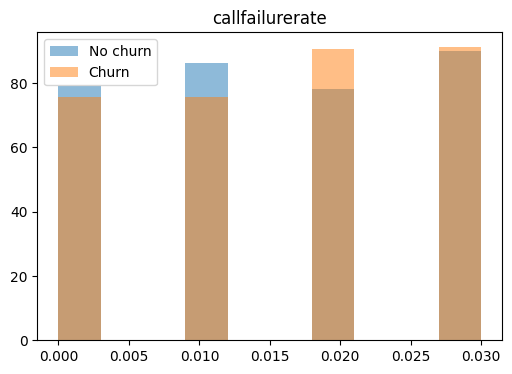

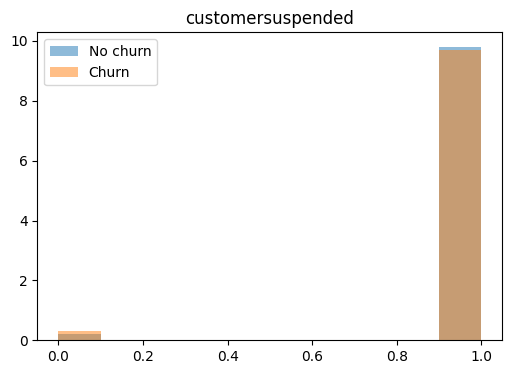

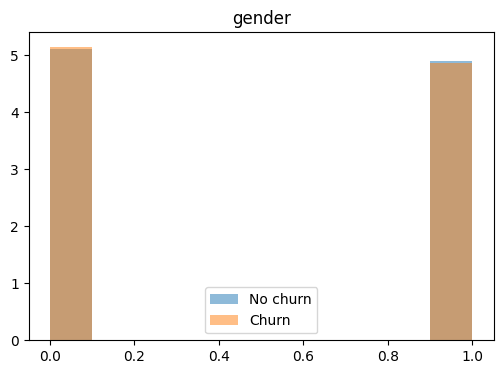

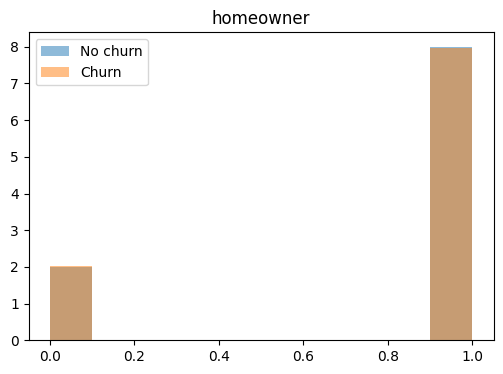

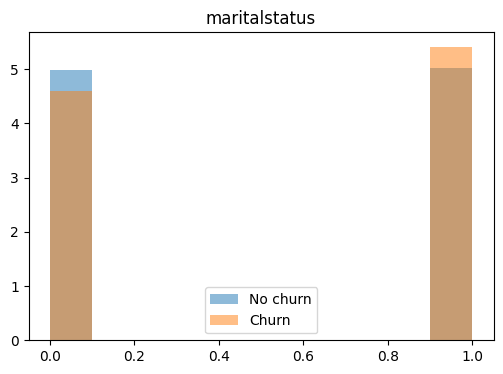

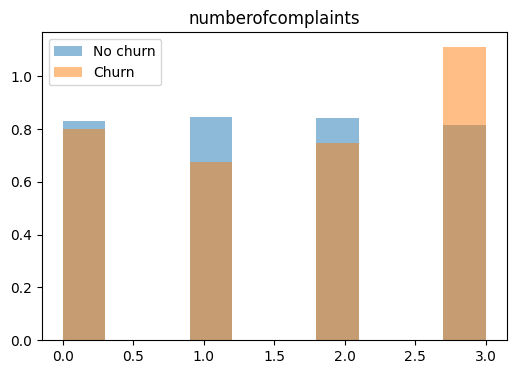

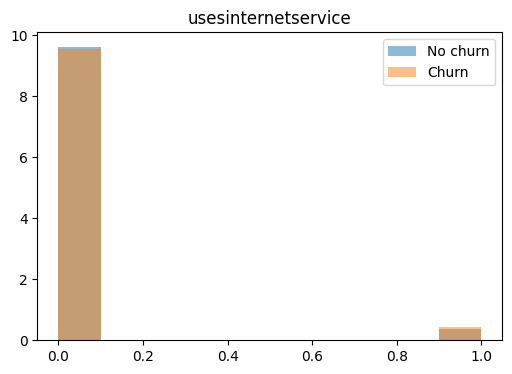

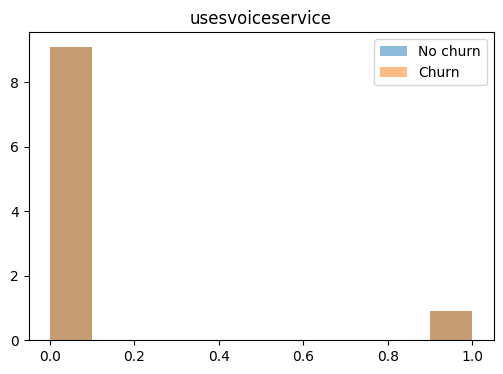

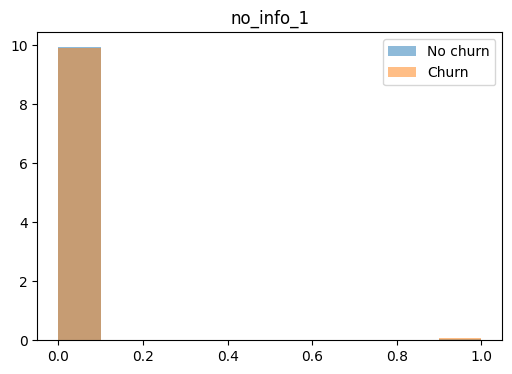

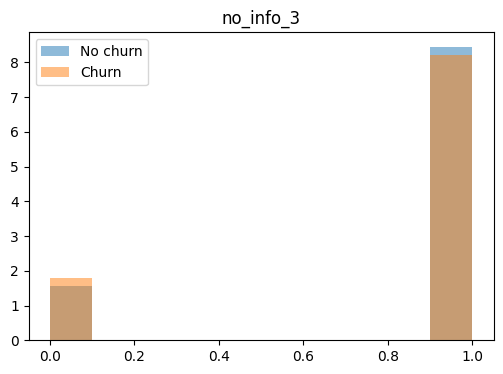

In [53]:
discrete = train[numeric_variables].nunique()
discrete_variables = discrete[discrete < 5].index.tolist()

for feature in discrete_variables:
  var_target_0 = train.loc[train[TARGET_NAME] == 0, feature]
  var_target_1 = train.loc[train[TARGET_NAME] == 1, feature]

  plt.figure(figsize=(6, 4))

  plt.hist(var_target_0, density=True, alpha=0.5, label='No churn')
  plt.hist(var_target_1, density=True, alpha=0.5, label='Churn')
  plt.title(feature)
  plt.legend();

In [54]:
for feature in discrete_variables:
  print(f'{train.groupby(feature)[TARGET_NAME].mean().sort_index()}\n')

callfailurerate
0.00    0.087095
0.01    0.080305
0.02    0.103340
0.03    0.091616
Name: churn, dtype: float64

customersuspended
0    0.128571
1    0.089628
Name: churn, dtype: float64

gender
0    0.091069
1    0.089795
Name: churn, dtype: float64

homeowner
0    0.091181
1    0.090261
Name: churn, dtype: float64

maritalstatus
0    0.083965
1    0.096793
Name: churn, dtype: float64

numberofcomplaints
0    0.087719
1    0.073361
2    0.081032
3    0.119288
Name: churn, dtype: float64

usesinternetservice
0    0.089874
1    0.104651
Name: churn, dtype: float64

usesvoiceservice
0    0.090340
1    0.091514
Name: churn, dtype: float64

no_info_1
0    0.090237
1    0.125000
Name: churn, dtype: float64

no_info_3
0    0.102759
1    0.088141
Name: churn, dtype: float64



In [55]:
selected_discrete = ['callfailurerate', 'numberofcomplaints']

In [56]:
selected_vars_Chi2_discrete = []
for feature in discrete_variables:
  churn = train.loc[train[TARGET_NAME]==1, feature].values
  no_churn = train.loc[train[TARGET_NAME]==0, feature].values

  df_bins = pd.DataFrame()
  df_bins['bin'] = train.loc[df[TARGET_NAME]==1, feature].value_counts().sort_index().index
  df_bins['no_churn_observed'] = train.loc[
      train[TARGET_NAME]==0, feature
  ].value_counts().sort_index().values
  df_bins['churn_observed'] = train.loc[
      train[TARGET_NAME]==1, feature
  ].value_counts().sort_index().values

  df_bins['churn_expected'] = df_bins['no_churn_observed'] / np.sum(df_bins['no_churn_observed']) * np.sum(df_bins['churn_observed'])
  stat, p_value = chisquare(df_bins['churn_observed'], df_bins['churn_expected'])

  if p_value < 0.05:
      selected_vars_Chi2_discrete.append(feature)
      print(f"{feature}\nChi-squared Test: statistic={stat:.4f}, p-value={p_value:.4f}\n")
      print(f'{df_bins}\n')

numberofcomplaints
Chi-squared Test: statistic=27.8305, p-value=0.0000

   bin  no_churn_observed  churn_observed  churn_expected
0    0               1508             145      149.954485
1    1               1541             122      153.235983
2    2               1531             135      152.241590
3    3               1484             201      147.567942



* В переменной numberofcomplaints наше p-значение ниже 5%, поэтому с достоверностью 95% отвергаем нулевую гипотезу об одинаковости двух распределений.

numberofcomplaints
Kolmogorov-Smirnov Test: statistic=0.0886, p-value=0.0003



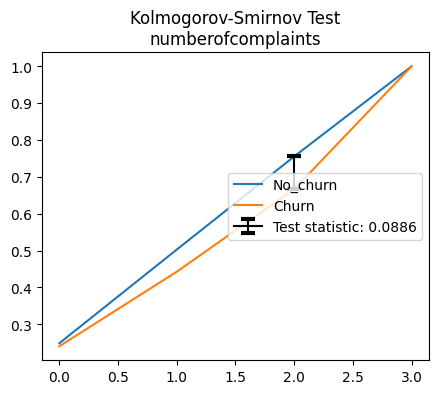

In [57]:
selected_vars_KS_discrete = []
for feature in discrete_variables:
  churn = train.loc[train[TARGET_NAME]==1, feature].values
  no_churn = train.loc[train[TARGET_NAME]==0, feature].values

  stat, p_value = kstest(churn, no_churn)
  if  p_value < 0.05:
    print(f"{feature}\nKolmogorov-Smirnov Test: statistic={stat:.4f}, p-value={p_value:.4f}\n")
    selected_vars_KS_discrete.append(feature)
    plot_ks_test(df, feature)

In [58]:
selected_vars_discrete = list(
    set(selected_discrete + selected_vars_KS_discrete + selected_vars_Chi2_discrete)
)
selected_vars_discrete

['numberofcomplaints', 'callfailurerate']

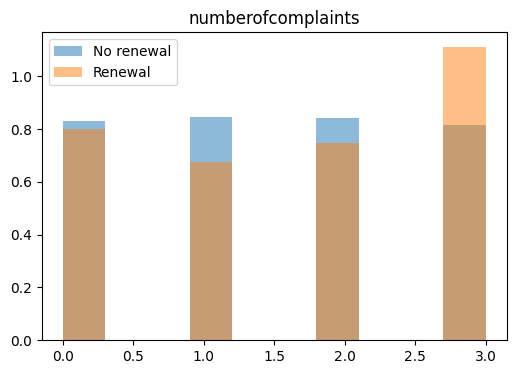

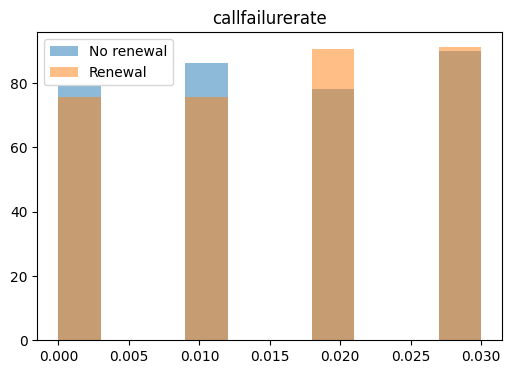

In [59]:
for feature in selected_vars_discrete:
  plt.figure(figsize=(6, 4))
  var_target_0 = train.loc[train[TARGET_NAME] == 0, feature]
  var_target_1 = train.loc[train[TARGET_NAME] == 1, feature]

  plt.hist(var_target_0, density=True, alpha=0.5, label='No renewal')
  plt.hist(var_target_1, density=True, alpha=0.5, label='Renewal')
  plt.title(feature)
  plt.legend();

#### B. Непрерывные переменные

In [60]:
continuous_variables = [i for i in numeric_variables if not i in discrete_variables]

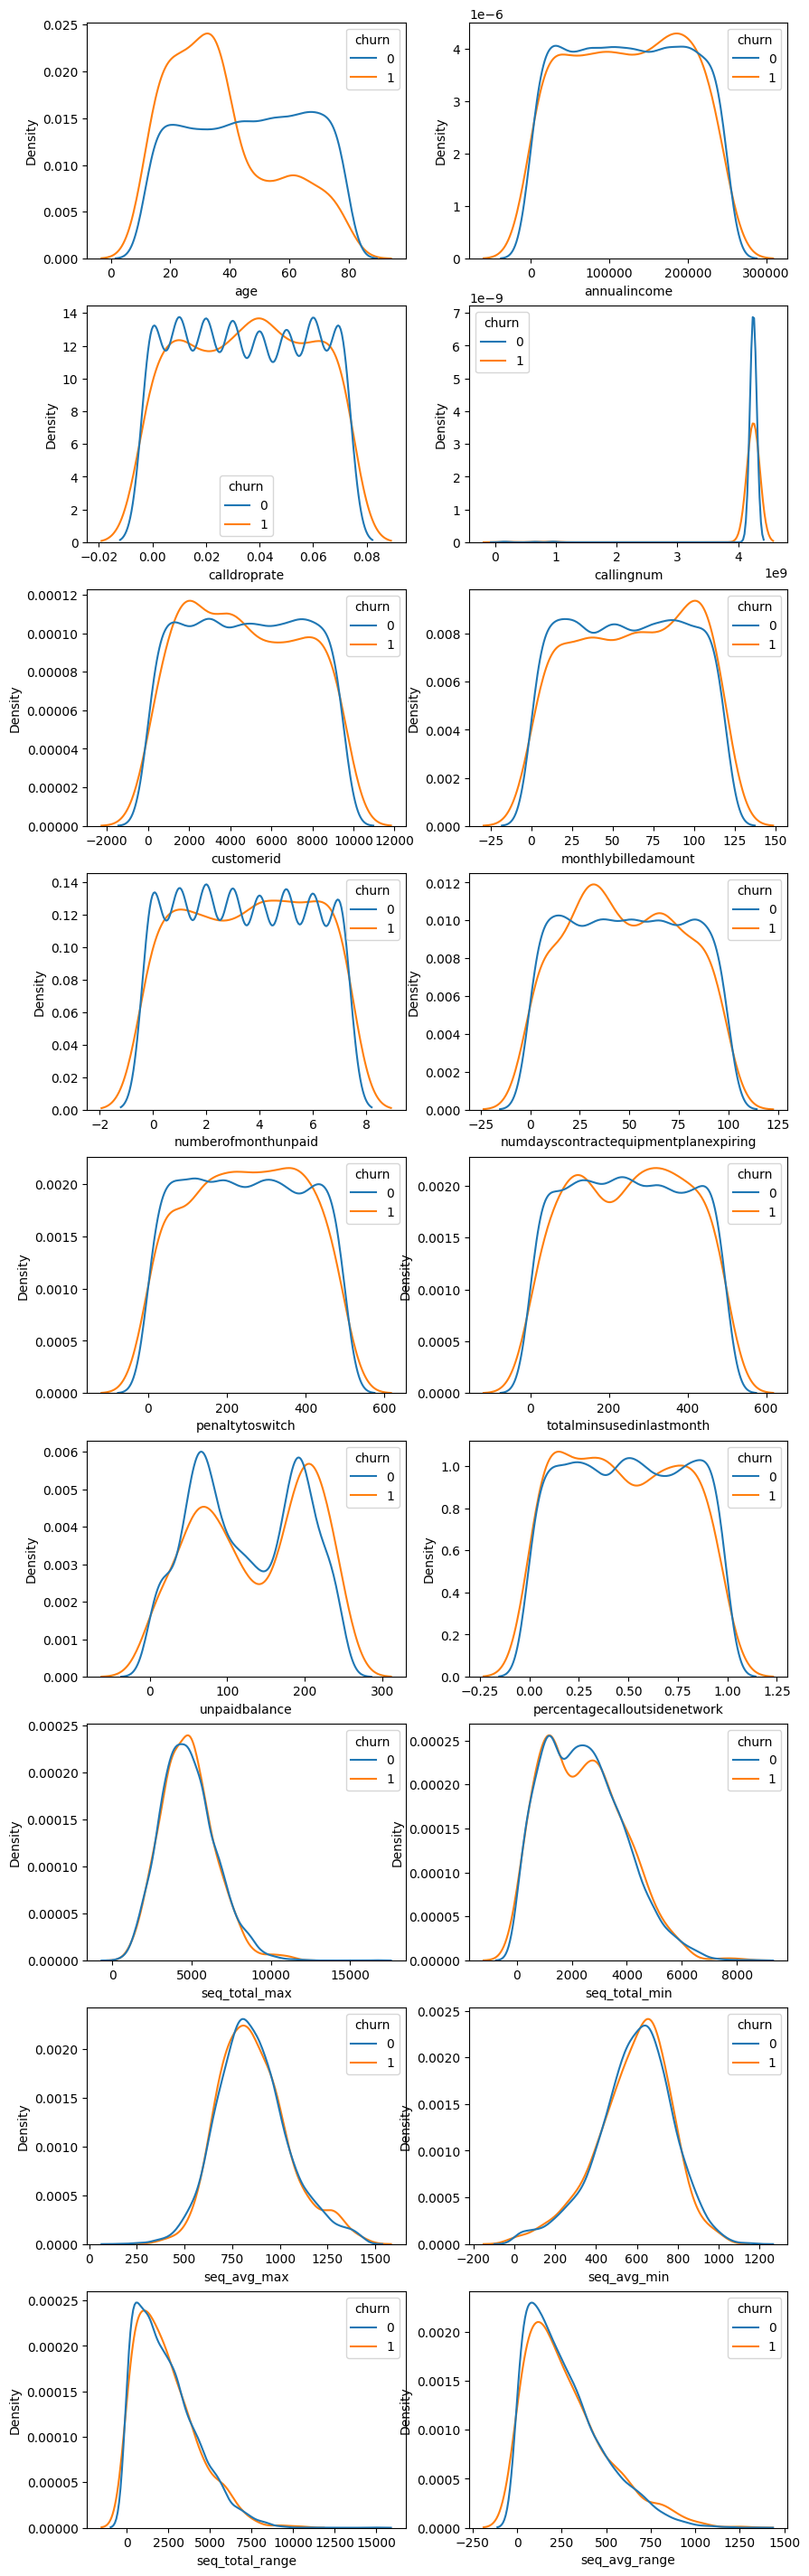

In [61]:
fig, axes = plt.subplots(9, 2, figsize=(10, 36))
for num, feature in enumerate(continuous_variables):
  sns.kdeplot(train, x=feature, hue=TARGET_NAME, ax=axes[num//2, num%2], common_norm=False)

##### Тест хи-квадрат

In [62]:
selected_vars_Chi2 = []
for feature in continuous_variables:
  if feature in ['calldroprate', 'numberofmonthunpaid',]:
    continue
  churn = train.loc[train[TARGET_NAME]==1, feature].values
  no_churn = train.loc[train[TARGET_NAME]==0, feature].values

  df_bins = pd.DataFrame()

  # Generate bins from control group
  _, bins = pd.qcut(no_churn, q=10, retbins=True)
  df_bins['bin'] = pd.cut(no_churn, bins=bins).value_counts().index

  # Apply bins to both groups
  df_bins['no_churn_observed'] = pd.cut(no_churn, bins=bins).value_counts().values
  df_bins['churn_observed'] = pd.cut(churn, bins=bins).value_counts().values

  # Compute expected frequency in the treatment group
  df_bins['churn_expected'] = df_bins['no_churn_observed'] / np.sum(df_bins['no_churn_observed']) * np.sum(df_bins['churn_observed'])


  stat, p_value = chisquare(df_bins['churn_observed'], df_bins['churn_expected'])

  if p_value < 0.05:
    selected_vars_Chi2.append(feature)
    print(f"{feature}\nChi-squared Test: statistic={stat:.4f}, p-value={p_value:.4f}\n")
    print(f'{df_bins}\n')

age
Chi-squared Test: statistic=194.5387, p-value=0.0000

            bin  no_churn_observed  churn_observed  churn_expected
0  (12.0, 18.0]                545              83       53.661819
1  (18.0, 25.0]                598              91       58.880308
2  (25.0, 33.0]                664             108       65.378803
3  (33.0, 40.0]                594             116       58.486459
4  (40.0, 47.0]                625              30       61.538783
5  (47.0, 53.0]                541              36       53.267971
6  (53.0, 60.0]                633              28       62.326479
7  (60.0, 67.0]                663              42       65.280341
8  (67.0, 73.0]                571              29       56.221832
9  (73.0, 79.0]                548              26       53.957205

unpaidbalance
Chi-squared Test: statistic=36.7210, p-value=0.0000

              bin  no_churn_observed  churn_observed  churn_expected
0     (0.0, 35.0]                613              58       60.884647

* В переменных age, unpaidbalance и percentagecalloutsidenetwork наше p-значение ниже 5%, поэтому с достоверностью 95% отвергаем нулевую гипотезу об одинаковости двух распределений.

##### Критерий Колмогорова — Смирнова

age
Kolmogorov-Smirnov Test: statistic=0.2808, p-value=0.0000

unpaidbalance
Kolmogorov-Smirnov Test: statistic=0.1174, p-value=0.0000



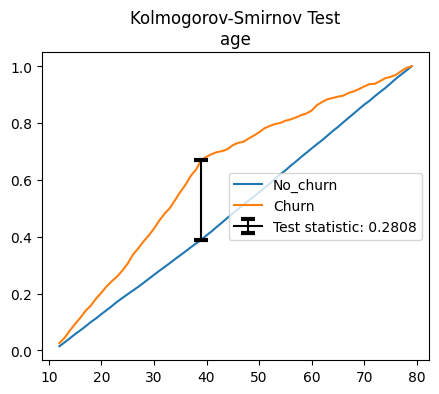

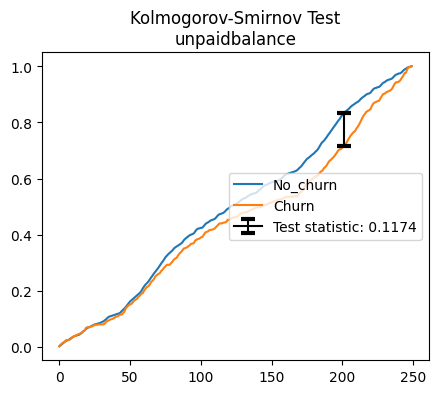

In [63]:
selected_vars_KS = []
for feature in continuous_variables:
  churn = df.loc[df[TARGET_NAME]==1, feature].values
  no_churn = df.loc[df[TARGET_NAME]==0, feature].values

  stat, p_value = kstest(churn, no_churn)
  if  p_value < 0.05:
    print(f"{feature}\nKolmogorov-Smirnov Test: statistic={stat:.4f}, p-value={p_value:.4f}\n")
    selected_vars_KS.append(feature)
    plot_ks_test(df, feature)

* В переменных age и unpaidbalance наше p-значение ниже 5%, поэтому с достоверностью 95% отвергаем нулевую гипотезу об одинаковости двух распределений.

In [64]:
selected_vars_continuous = [i for i in numeric_variables if i in set(selected_vars_Chi2 + selected_vars_KS)]
selected_vars_continuous

['age', 'unpaidbalance']

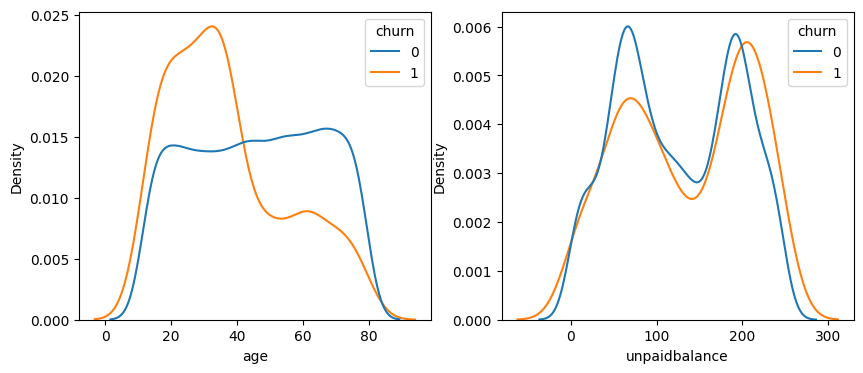

In [65]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

for num, feature in enumerate(selected_vars_continuous):
  sns.kdeplot(train, x=feature, hue=TARGET_NAME, ax=axes[num%2], common_norm=False)

In [66]:
selected_numeric_features = selected_vars_discrete + selected_vars_continuous
selected_numeric_features

['numberofcomplaints', 'callfailurerate', 'age', 'unpaidbalance']

In [67]:
scaler_num = StandardScaler()

train[selected_numeric_features] = scaler_num.fit_transform(train[selected_numeric_features])
valid[selected_numeric_features] = scaler_num.transform(valid[selected_numeric_features])
test[selected_numeric_features] = scaler_num.transform(test[selected_numeric_features])

In [68]:
selected_features = selected_numeric_features + categorical_variables
selected_features

['numberofcomplaints',
 'callfailurerate',
 'age',
 'unpaidbalance',
 'customersuspended',
 'gender',
 'homeowner',
 'maritalstatus',
 'usesinternetservice',
 'usesvoiceservice']